<a href="https://colab.research.google.com/github/Hurri301/Advanced-Computational-Techniques-for-Big-Imaging-and-Signal-Data/blob/main/lucas_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 5.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.tensorboard import SummaryWriter
import torchmetrics
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import pandas as pd
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, csv, src_prefix='spc.'):
        self.df = pd.read_csv(csv, sep=',')
        self.output_cols = ['coarse','clay','silt','sand','pH.in.CaCl2','pH.in.H2O','OC','CaCO3','N','P','K','CEC']
        self.input_cols = [col for col in self.df.columns if col.startswith(src_prefix)]
        x = np.array([float(col[len(src_prefix):]) for col in self.input_cols])
        pos = np.argsort(x)
        self.input_cols = [self.input_cols[cur_pos] for cur_pos in pos]

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        cur_sample = self.df.iloc[idx]
        cur_sample_x = cur_sample[self.input_cols]
        cur_sample_y = cur_sample[self.output_cols]
        cur_sample_x = torch.tensor(cur_sample_x.tolist())
        cur_sample_y = torch.tensor(cur_sample_y.tolist())
        return cur_sample_x, cur_sample_y


In [5]:
# get validation set
ds = Dataset('/content/drive/MyDrive/lucas_dataset_val.csv')
# get first item
inp, out = ds.__getitem__(0)
# print shapes
print(inp.shape)
print(out.shape)

torch.Size([4200])
torch.Size([12])


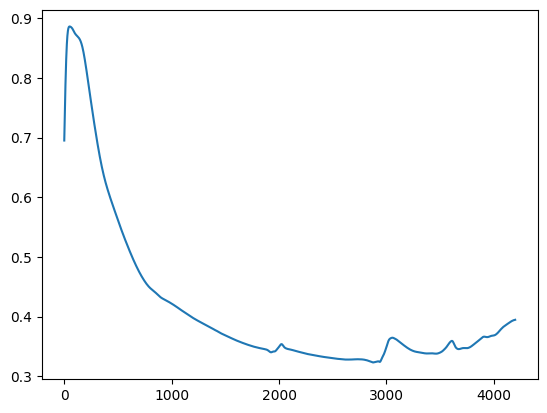

In [6]:
# plot it
plt.plot(inp)
plt.show()

**Define the CNN Model**

In [7]:
class SoilCNN(nn.Module):
    def __init__(self):
        super(SoilCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.relu = nn.ReLU()

        # Calculate the size after convolution and pooling
        self._to_linear = None
        self.convs(torch.randn(1, 1, 4200))  # Dummy forward pass to calculate the output size
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 12)

    def convs(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        if self._to_linear is None:
            self._to_linear = x.view(x.size(0), -1).size(1)
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameters
learning_rate = 0.001
batch_size = 16
num_epochs = 10

# Dataset and DataLoader
csv_file = '/content/drive/MyDrive/lucas_dataset_val.csv'
dataset = Dataset(csv_file)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Instantiate the model, loss function, and optimizer
model = SoilCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [8]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, targets in train_loader:
        inputs = inputs.unsqueeze(1).float()
        targets = targets.float()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs = inputs.unsqueeze(1).float()
            targets = targets.float()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)

    val_loss /= len(val_loader.dataset)
    print(f'Validation Loss: {val_loss:.4f}')

# Save the model
torch.save(model.state_dict(), 'soil_cnn_model.pth')


Epoch [1/10], Loss: 6187.1201
Validation Loss: 4642.9542
Epoch [2/10], Loss: 5753.5842
Validation Loss: 4425.1076
Epoch [3/10], Loss: 5575.3295
Validation Loss: 4335.1257
Epoch [4/10], Loss: 5422.2095
Validation Loss: 4418.4073
Epoch [5/10], Loss: 5218.9153
Validation Loss: 4449.6447
Epoch [6/10], Loss: 5121.4055
Validation Loss: 4042.6869
Epoch [7/10], Loss: 4955.1476
Validation Loss: 3984.2826
Epoch [8/10], Loss: 4909.2571
Validation Loss: 4073.7540
Epoch [9/10], Loss: 4871.4331
Validation Loss: 4228.9101
Epoch [10/10], Loss: 4789.5443
Validation Loss: 3884.6634


**Mastering PCA**

In [9]:
import torch
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Load the validation set
df_val = pd.read_csv('/content/drive/MyDrive/lucas_dataset_val.csv')

# Extract features
src_prefix = 'spc.'
input_cols = [col for col in df_val.columns if col.startswith(src_prefix)]
X = df_val[input_cols].values

# Standardize the data
X_std = (X - X.mean(axis=0)) / X.std(axis=0)

# Compute PCA
pca = PCA(n_components=0.9)  # Retain 90% variance
X_pca = pca.fit_transform(X_std)

# Print the number of principal components
num_components = pca.n_components_
print("Number of principal components survived:", num_components)

Number of principal components survived: 1


In [10]:
# Invert PCA transformation
X_inverse = pca.inverse_transform(X_pca)

# Print the shape of the inverted data to ensure it matches the original data
print("Shape of inverted data:", X_inverse.shape)

Shape of inverted data: (2000, 4200)


Original signal had 4200 components, PCA reduced it to 2 components.


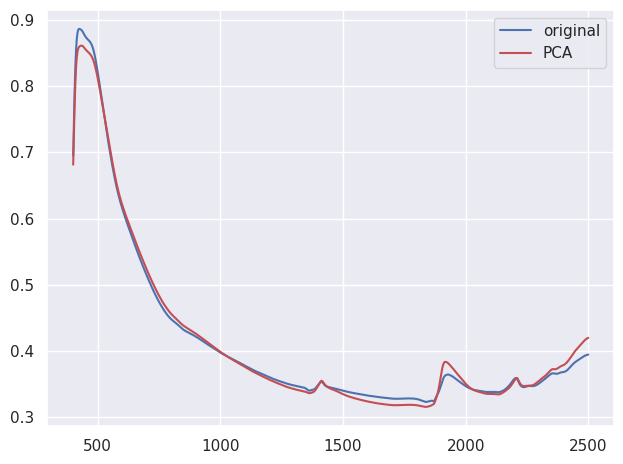

In [17]:
import os
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns

sns.set_theme()




def get_src(df, src_prefix):
    ''' gets hyperspectral signals using cols starting with src_prefix '''
    # get x points
    src_cols = [col for col in df.columns if col.startswith(src_prefix)]
    x = np.array([float(col[len(src_prefix):]) for col in src_cols])
    # sort x points in increasing order
    pos = np.argsort(x)
    src_cols = [src_cols[cur_pos] for cur_pos in pos]
    # extract x and y values
    src_x = x[pos]
    src_y = df[src_cols].to_numpy()
    # convert to tensor
    src_x = torch.from_numpy(src_x).float()
    src_y = torch.from_numpy(src_y).float()
    # return
    return src_cols, src_x, src_y


def get_tgt(df, tgt_vars):
    ''' gets target variables using specified columns '''
    # extract variables
    tgt_vars = df[tgt_vars].to_numpy()
    # convert to torch
    tgt_vars = torch.from_numpy(tgt_vars).float()
    # return them
    return tgt_vars


def load_data(fn):
    # read csv
    df = pd.read_csv(fn)
    # get vars
    src_cols, src_x, src_y = get_src(df, src_prefix)
    # return
    return df, src_cols, src_x, src_y



if __name__ == '__main__':
    # define input file
    data_fn = '/content/lucas_dataset_val.csv'
    src_prefix = 'spc.'
    n_components = 0.9
    # read file
    df, src_cols, src_x, src_y = load_data(data_fn)
    # apply pca
    pca = PCA(n_components=n_components)
    # fit and transform
    components = pca.fit_transform(src_y)
    # print shape
    print('Original signal had {} components, PCA reduced it to {} components.'.format(src_y.shape[1], components.shape[1]))
    # invert components
    inverted = pca.inverse_transform(components)
    # plot according to values
    plt.plot(src_x, src_y[0], 'b', label='original')
    plt.plot(src_x, inverted[0], 'r', label='PCA')
    plt.legend()
    plt.tight_layout()
    plt.savefig('pca.png', dpi=300)
    # plt.show()
